# 16 - TensorFlow - Keras: Clasificación de tendencias politicas en tweets (Perceptrón Multicapa)

* En este notebook vamos a clasificar una serie de tweets etiquetados por un partido político (psoe, pp, vox, podemos y ciudadanos) que corresponden a la tendencia politica de la cuenta que publicó ese tweet,


* El ejercicio que vamos a realizar a continuación es muy similar al realizado en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb* y se pueden comparar los resultados que vamos a obtener con la Red Neuronal respecto a los obtenidos con los modelos generados por los algoritmos de clasificación vistos.


* Los pasos que vamos a dar son los siguientes:

    1. Cargar los datos
    2. Normalizar los tweets (igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb*)
    3. Particionado de datos (Train y Test)
    4. Bolsa de palabras y codificación del target
    5. Definición de la Red Neuronal
    6. Entrenamiento de la Red Neuronal
    7. Evaluación del modelo

<hr>


## Carga de Datos


* El fichero que contiene los tweets lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos y mostramos una muestra:

In [1]:
import pandas as pd

TWEETS_FILE = './data/tweets_politica.csv'
df = pd.read_csv(TWEETS_FILE, sep='::::', engine='python', error_bad_lines=False)

# Eliminamos los tweets que tengan algún valor a nulo
df = df.dropna()
print('Número de Tweets Cargados: {num}'.format(num=df.shape[0]))

# Imprimimos el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets Cargados: 91809
Número de Tweets a procesar: 91809


,cuenta,partido,timestamp,tweet
648,sanchezcastejon,psoe,1.555152e+09,La derecha y sus 3 siglas suponen un triple ri...
40149,IratxeGarper,psoe,1.578055e+09,Comienza el año preparados para un nuevo gobie...
44889,TeresaRodr_,podemos,1.579179e+09,Andalucía tiene una desventaja histórica con r...
50664,Ibangarciadb,psoe,1.581082e+09,@nicogoncas https://t.co/8HVRpQolK7
42552,ahorapodemos,podemos,1.578392e+09,Hoy es un día histórico. Tras una década perdi...
85605,hermanntertsch,vox,1.614580e+09,Aznar sigue celebrando en El Escorial. Es tan ...
63658,PSOE,psoe,1.584875e+09,🔴Director del Centro de Coordinación de Alerta...
70211,IdiazAyuso,pp,1.608200e+09,Qué razón tuvo aquel que dijo “por qué no te c...
44943,sirarego,podemos,1.579098e+09,🔻 En la nueva sesión de anticomunismo que nos ...
47516,Santi_ABASCAL,vox,1.579856e+09,Gran iniciativa de nuestra diputada Reyes Rome...


* Filtramos los tweets por fecha. Nos quedamos con los tweets a partir de una fecha dada.

In [2]:
import datetime
import time

# Filtramos los tweets a partir de una fecha
DATE = "01/03/2020"
timestamp = time.mktime(datetime.datetime.strptime(DATE, "%d/%m/%Y").timetuple())
df = df[df.timestamp >= timestamp]

# Mostramos un sample y el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets a procesar: 35316


,cuenta,partido,timestamp,tweet
66037,lugaricano,ciudadanos,1.585313e+09,"@ernesturtasun @publico_es Ernest, las democra..."
79225,hermanntertsch,vox,1.612258e+09,"""El PSOE es un gran partido"" al que siempre qu..."
62617,abalosmeco,psoe,1.584641e+09,Quiero trasladar un mensaje de confianza respe...
66850,gonzalezpons,pp,1.585470e+09,Amor de juventud en tiempos del coronavirus. S...
81539,PabloEchenique,podemos,1.612969e+09,El grupo parlamentario de Unidas Podemos-En Co...
90913,isaserras,podemos,1.616488e+09,Los discursos machistas contra Yolanda Diaz o ...
73616,isaserras,podemos,1.610109e+09,En la Cañada Real denunciando la situación q e...
78867,PabloEchenique,podemos,1.612083e+09,VOX. https://t.co/ag3oEfRnHB
88560,JuanMarin_Cs,ciudadanos,1.615536e+09,Ahora es momento de generar confianza para sal...
70990,Yolanda_Diaz_,podemos,1.608064e+09,@arsenioescolar @clabe_editores Toda la suerte...


* Tweets publicados por partido político

In [3]:
df.groupby('partido')['tweet'].count().reset_index().sort_values(by='tweet', ascending=False)

,partido,tweet
4,vox,7934
3,psoe,7442
0,ciudadanos,7045
1,podemos,6649
2,pp,6246


* Nos quedamos solo con el nombre del partido y el tweet

In [4]:
tweets = [tuple(x) for x in df[['tweet', 'partido']].values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 35316


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: Se pueden realizar más acciones de normalización que las realizadas, como tratamiento de emoticonos, tratamiento especial de referencia a cuentas, hashtags, etc. Al tratarse de un ejemplo didáctica se ha realizado una normalización '*sencilla*'.

In [5]:
import numpy as np
import spacy

from tqdm import tqdm

nlp = spacy.load('es_core_news_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = np.array([doc[1] for doc in tweets])

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(tqdm(sentenses)):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        sentense = nlp(sentense.lower().replace('.', ' ').replace('#', ' ').strip())
        # Puntos 4,5,6,7 y 8
        sentenses[index] = ([word.lemma_ for word in sentense if (not word.is_punct)
                             and (len(word.text) > 2) and (not word.is_stop)
                             and (not word.text.startswith('@'))
                             and (not word.text.startswith('http'))
                             and (not ':' in word.text)])
    return sentenses

# Normalizamos las frases
X_norm = normalize(X)

100%|██████████| 35316/35316 [04:32<00:00, 129.72it/s]


<hr>


## Particionado de Datos (Train y Test)

* Dado que las temáticas de los tweets varian en función del tiempo (tienen caracter temporal), vamos a particionar los datos temporalmente.


* Seleccionaremos como tweets de entrenamiento aquellos que se han escrito hasta una determinada fecha y como tweets de test los últimos tweets escritos.


* Seleccionaremos un 5% de tweets de test, siendo estos los últimos tweets registrados en el dataset (los tweets están escritos de manera cronológica).


* Por tanto nos vamos a quedar con:
    - 95% de datos de entrenamiento
    - 5% de datos de test

In [6]:
PCT_TEST = 0.05
n_tail = len(X_norm) - int(len(X_norm) * PCT_TEST)
print('Corte en el tweet número {} de los {} tweets del Dataset.'.format(n_tail, len(X_norm)))

X_train = X_norm[:n_tail]
y_train = y[:n_tail]
X_test = X_norm[n_tail:]
y_test = y[n_tail:]

print('Tweets de entrenamiento: {}'.format(len(X_train)))
print('Tweets de Test: {}'.format(len(X_test)))


Corte en el tweet número 33551 de los 35316 tweets del Dataset.
Tweets de entrenamiento: 33551
Tweets de Test: 1765


<hr>


# Bolsa de palabras y codificación del target


* Al igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb* vamos a trabajar con las 1000 palabras de mayor frecuencia del corpus.


* Realizaremos una codificación del nombre del partido político utilizando la clase "LabelEncoder()" de scikit.

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer


# Bolsa de Palabras
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_matrix = tokenizer.texts_to_matrix(X_train, mode='count')
X_matrix_test = tokenizer.texts_to_matrix(X_test, mode='count')

# Codificación del Target
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

<hr>


# Definición de la Red Neuronal



* Para clasificar los tweets en alguna de las 4 tendencias políticas definidas, vamos a crear una red con la siguiente arquitectura:
<span></span><br><br>
    - ***Capa 1***: Capa de entrada con 1000 Neuronas (una por palabra del corpus)
<span></span><br><br>
    - ***Capa 2***: 20 Neuronas con una función de activación 'relu'
<span></span><br><br>
    - ***Capa 3***: 10 Neuronas con una función de activación 'relu'
<span></span><br><br>
    - ***Capa 4***: Capa de salida con 5 neurona (una por tendencia política) y una función de activación 'softmax' para que nos "normalice la salida"
    
    
* Para las capas 2 y 3 vamos a poner un dropout del 20% para que nuestra red no se sobreajuste y generalize mejor


* Por último vamos a compilar la red:
<span></span><br><br>
    - ***Función de perdida: 'categorical_crossentropy'*** (Funciones de Perdida: https://keras.io/losses/)
<span></span><br><br>
    - ***Optimizador: 'adam'*** (Optimizadores: https://keras.io/optimizers/)
<span></span><br><br>
    - Metricas: en cada epoch pediremos que nos muestre el accuracy.

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics

np.random.seed(9)
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=max_words))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


* Una vez creada la red mostramos su arquitectura:
    - 1000 Neuronas de entrada
    - Capa 2: 20 Neuronas
    - Conexiones "capa de entrada -> Capa 2" = (1000*20) + 20 = 20020 Conexiones
    - Capa 3: 10 Neuronas
    - Conexiones "Capa 2 -> Capa 3" = (20*10) + 10 = 210 Conexiones
    - Capa de salida: 4 Neuronas
    - Conexiones "Capa 3 -> Capa de salida" = (10*5) + 5 = 55 Conexiones

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                20020     
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 20,285
Trainable params: 20,285
Non-trainable params: 0
_________________________________________________________________


<hr>


# Entrenamiento de la Red Neuronal


* Como lo que estamos haciendo es un ejemplo didáctico vamos a poner los siguientes valores:
<span></span><br><br>
    - *batch_size = 64* : Cada 64 tweets se calculan los nuevos pesos de la red
<span></span><br><br>
    - *epochs = 200*
<span></span><br><br>
    - *validation_split = 0.1* 


In [10]:

history = model.fit(X_matrix, y_train, batch_size=64, epochs=200, verbose=2, validation_split=0.1)


Epoch 1/200
472/472 - 0s - loss: 1.4785 - accuracy: 0.3458 - val_loss: 1.3343 - val_accuracy: 0.4791
Epoch 2/200
472/472 - 0s - loss: 1.2587 - accuracy: 0.4784 - val_loss: 1.2351 - val_accuracy: 0.5137
Epoch 3/200
472/472 - 0s - loss: 1.1848 - accuracy: 0.5210 - val_loss: 1.2291 - val_accuracy: 0.5164
Epoch 4/200
472/472 - 0s - loss: 1.1479 - accuracy: 0.5374 - val_loss: 1.2316 - val_accuracy: 0.5086
Epoch 5/200
472/472 - 0s - loss: 1.1257 - accuracy: 0.5514 - val_loss: 1.2341 - val_accuracy: 0.5101
Epoch 6/200
472/472 - 0s - loss: 1.1031 - accuracy: 0.5611 - val_loss: 1.2385 - val_accuracy: 0.5146
Epoch 7/200
472/472 - 0s - loss: 1.0877 - accuracy: 0.5668 - val_loss: 1.2505 - val_accuracy: 0.5119
Epoch 8/200
472/472 - 0s - loss: 1.0748 - accuracy: 0.5734 - val_loss: 1.2566 - val_accuracy: 0.5176
Epoch 9/200
472/472 - 0s - loss: 1.0608 - accuracy: 0.5789 - val_loss: 1.2608 - val_accuracy: 0.5137
Epoch 10/200
472/472 - 0s - loss: 1.0493 - accuracy: 0.5856 - val_loss: 1.2689 - val_accura

Epoch 82/200
472/472 - 0s - loss: 0.8369 - accuracy: 0.6714 - val_loss: 1.7197 - val_accuracy: 0.4988
Epoch 83/200
472/472 - 0s - loss: 0.8407 - accuracy: 0.6689 - val_loss: 1.7297 - val_accuracy: 0.4961
Epoch 84/200
472/472 - 0s - loss: 0.8328 - accuracy: 0.6703 - val_loss: 1.7356 - val_accuracy: 0.4911
Epoch 85/200
472/472 - 0s - loss: 0.8346 - accuracy: 0.6724 - val_loss: 1.7416 - val_accuracy: 0.4955
Epoch 86/200
472/472 - 0s - loss: 0.8381 - accuracy: 0.6700 - val_loss: 1.7510 - val_accuracy: 0.4973
Epoch 87/200
472/472 - 0s - loss: 0.8360 - accuracy: 0.6672 - val_loss: 1.7441 - val_accuracy: 0.4961
Epoch 88/200
472/472 - 0s - loss: 0.8302 - accuracy: 0.6720 - val_loss: 1.7469 - val_accuracy: 0.4970
Epoch 89/200
472/472 - 0s - loss: 0.8302 - accuracy: 0.6753 - val_loss: 1.7499 - val_accuracy: 0.4940
Epoch 90/200
472/472 - 0s - loss: 0.8319 - accuracy: 0.6744 - val_loss: 1.7634 - val_accuracy: 0.4964
Epoch 91/200
472/472 - 0s - loss: 0.8369 - accuracy: 0.6727 - val_loss: 1.7718 - v

Epoch 162/200
472/472 - 0s - loss: 0.7862 - accuracy: 0.6871 - val_loss: 2.1501 - val_accuracy: 0.4893
Epoch 163/200
472/472 - 0s - loss: 0.7918 - accuracy: 0.6876 - val_loss: 2.1420 - val_accuracy: 0.4896
Epoch 164/200
472/472 - 0s - loss: 0.7879 - accuracy: 0.6897 - val_loss: 2.1437 - val_accuracy: 0.4869
Epoch 165/200
472/472 - 0s - loss: 0.7940 - accuracy: 0.6862 - val_loss: 2.1501 - val_accuracy: 0.4860
Epoch 166/200
472/472 - 0s - loss: 0.7906 - accuracy: 0.6878 - val_loss: 2.1449 - val_accuracy: 0.4872
Epoch 167/200
472/472 - 0s - loss: 0.7902 - accuracy: 0.6867 - val_loss: 2.1534 - val_accuracy: 0.4952
Epoch 168/200
472/472 - 0s - loss: 0.7886 - accuracy: 0.6868 - val_loss: 2.1584 - val_accuracy: 0.4902
Epoch 169/200
472/472 - 0s - loss: 0.7935 - accuracy: 0.6863 - val_loss: 2.1616 - val_accuracy: 0.4899
Epoch 170/200
472/472 - 0s - loss: 0.7915 - accuracy: 0.6858 - val_loss: 2.1638 - val_accuracy: 0.4905
Epoch 171/200
472/472 - 0s - loss: 0.7909 - accuracy: 0.6874 - val_loss: 

* Pintamos como evoluciona la función de perdida y el Accuracy por epoch tanto en entrenamiento como en test.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Pintamos las métricas por epoch
def plot_metric(history, name, remove_first=0):
    metric_train = np.array(history.history[name])[remove_first:]
    metric_test = np.array(history.history['val_{}'.format(name)])[remove_first:]
    acum_avg_metric_train = (np.cumsum(metric_train) / (np.arange(metric_train.shape[-1]) + 1))[remove_first:]
    acum_avg_metric_test = (np.cumsum(metric_test) / (np.arange(metric_test.shape[-1]) + 1))[remove_first:]
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('{} - Epochs'.format(name))
    plt.plot(metric_train, label='{} Train'.format(name))
    plt.plot(metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.subplot(1, 2, 2)
    plt.title('AVG ACCUMULATIVE {} - Epochs'.format(name))
    plt.plot(acum_avg_metric_train, label='{} Train'.format(name))
    plt.plot(acum_avg_metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.show()

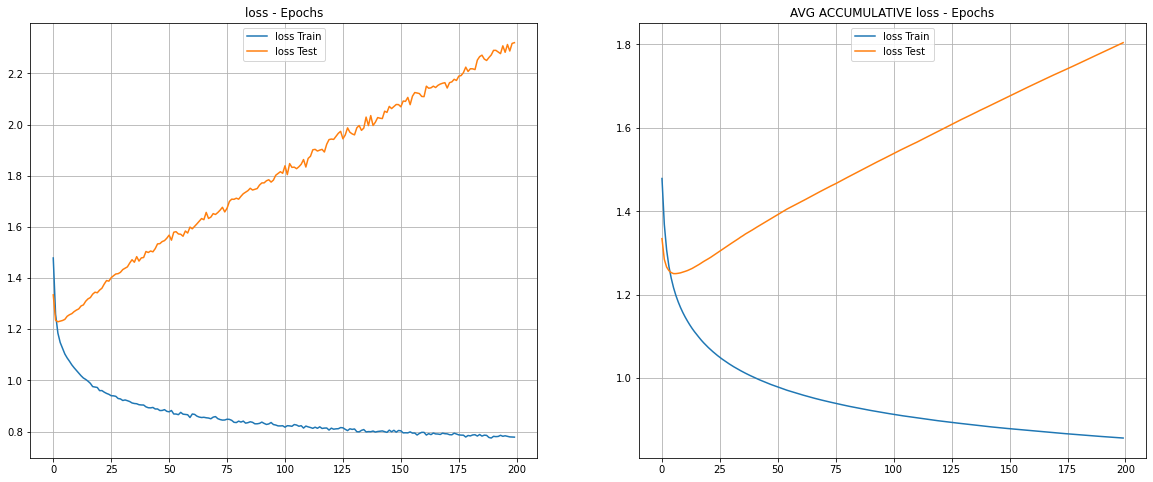

In [12]:
# Función de perdida
plot_metric(history=history, name='loss')

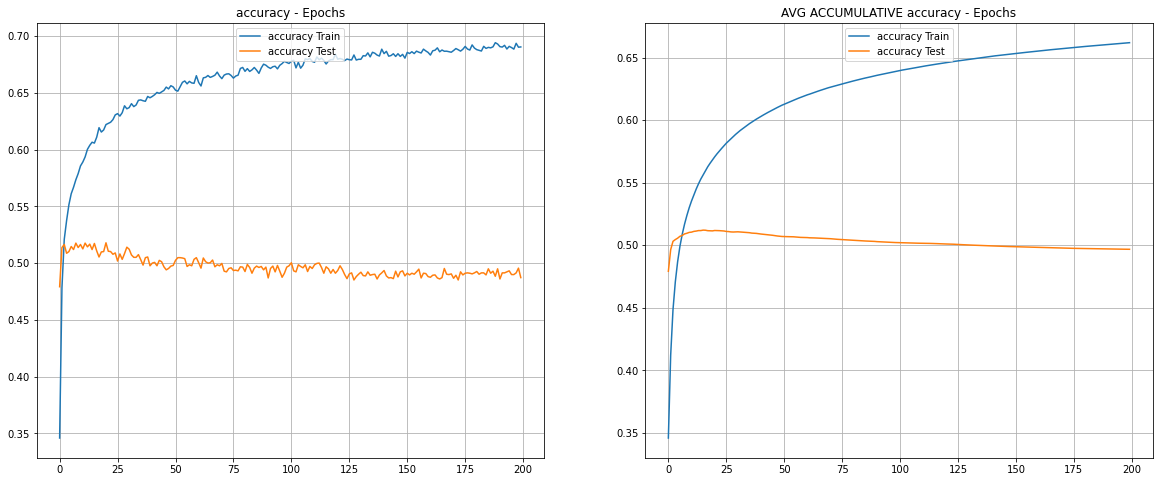

In [13]:
# Accuracy
plot_metric(history=history, name='accuracy')

<hr>


# Evaluamos el modelo

* Pasamos a evaluar el modelo, calculando las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **Precision**
    3. **Recall**
    4. **F1**

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

y_true = encoder.inverse_transform(y_test.reshape(-1))
y_pred = model.predict_classes(X_matrix_test)
y_pred = encoder.inverse_transform(y_pred.reshape(-1))

print('Accuracy: {acc:0.4f}'.format(acc=accuracy_score(y_true=y_true, y_pred=y_pred)))
print('F1: {f1:0.4f}'.format(f1=f1_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Precision: {pre:0.4f}'.format(pre=precision_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Recall: {rec:0.4f}'.format(rec=recall_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print(classification_report(y_true=y_true, y_pred=y_pred))
labels = ['psoe', 'pp', 'vox', 'podemos', 'ciudadanos']
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy: 0.4748
F1: 0.4700
Precision: 0.4802
Recall: 0.4748
              precision    recall  f1-score   support

  ciudadanos       0.47      0.40      0.43       333
     podemos       0.53      0.46      0.50       415
          pp       0.33      0.51      0.40       212
        psoe       0.43      0.28      0.34       297
         vox       0.54      0.64      0.58       508

    accuracy                           0.47      1765
   macro avg       0.46      0.46      0.45      1765
weighted avg       0.48      0.47      0.47      1765



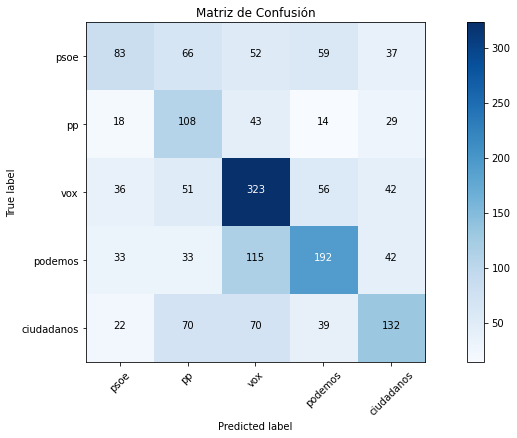

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Pintamos la matriz de confusión
plt.figure(figsize=(12, 6))
plot_confusion_matrix(confusion_matrix, classes=labels, title='Matriz de Confusión')
plt.show()